<a href="https://colab.research.google.com/github/ameliacode/Algorithm/blob/master/metrabs_demo_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MeTRAbs Absolute 3D Human Pose Estimator

István Sárándi, Timm Linder, Kai Oliver Arras, Bastian Leibe: "*MeTRAbs: Metric-Scale Truncation-Robust Heatmaps for Absolute 3D Human Pose Estimation.*"
In IEEE Transactions on Biometrics, Behavior, and Identity Science (T-BIOM), Selected Best Works From Automatic Face and Gesture Recognition (FG) 2020

* Repo: https://github.com/isarandi/metrabs
* Paper: https://arxiv.org/abs/2007.07227
* Conference talk: https://youtu.be/BemM8-Lx47g
* Qualitative result compilation: https://youtu.be/4VFKiiW9RCQ

In [ ]:
import tensorflow as tf
import os

def download_model(model_type):
    server_prefix = 'https://omnomnom.vision.rwth-aachen.de/data/metrabs'
    model_zippath = tf.keras.utils.get_file(
        origin=f'{server_prefix}/{model_type}_20211019.zip',
        extract=True, cache_subdir='models')
    model_path = os.path.join(os.path.dirname(model_zippath), model_type)
    return model_path

model = tf.saved_model.load(download_model('metrabs_mob3l_y4t')) # or metrabs_eff2l_y4 for the big model
! wget -q https://raw.githubusercontent.com/isarandi/metrabs/master/img/test_image_3dpw.jpg


In [ ]:
jumpStart = tf.image.decode_jpeg(tf.io.read_file('axel-start2.jpg'))
jumpEnd = tf.image.decode_jpeg(tf.io.read_file('axel-end.jpg'))

In [ ]:
pred = model.detect_poses(jumpStart, skeleton='smpl_24')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import animation
import matplotlib.image as mpimg

def visualize(image, im, detections, poses3d, poses2d, edges, gif_name = "test"):
    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image)
    image_ax.set_title("@Meli's SubLab")
    for x, y, w, h in detections[:, :4]:
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(5, -85)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(0, 3000)

    
    def rotate(angle):
        pose_ax.view_init(azim=angle)

    # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
    # Therefore, we do a 90° rotation around the X axis:
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, poses2d):
        for i_start, i_end in edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
            image_ax.text(pose2d[i_start][0],pose2d[i_start][1],  str(int(np.where(pose2d==pose2d[i_start][0])[0])), color = "yellow",size = 8)
            image_ax.text(pose2d[i_end][0],pose2d[i_end][1],  str(int(np.where(pose2d==pose2d[i_end][0])[0])), color = "red",size = 8)
            pose_ax.text(pose3d[i_start][0],pose3d[i_start][1], pose3d[i_start][2], str(int(np.where(pose3d==pose3d[i_start][0])[0])), color = "yellow",size = 8)
            pose_ax.text(pose3d[i_end][0],pose3d[i_end][1], pose3d[i_end][2], str(int(np.where(pose3d==pose3d[i_end][0])[0])), color = "red",size = 8)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)

    fig.tight_layout()
    plt.show()
    

    angle = 3
    ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
    ani.save(gif_name+'.gif', writer=animation.PillowWriter(fps=20))

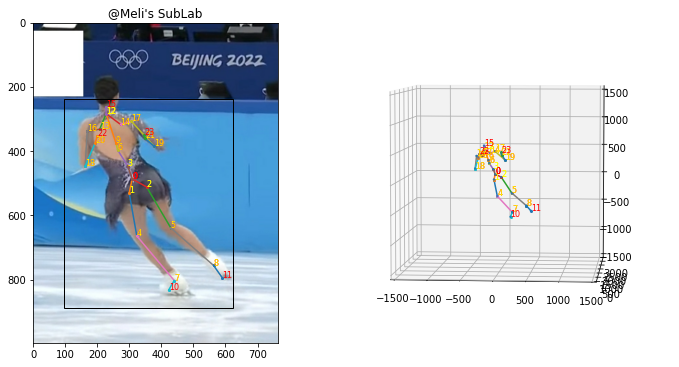

In [ ]:
visualize(
    jumpStart,
    jumpStart.numpy(), 
    pred['boxes'].numpy(),
    pred['poses3d'].numpy(),
    pred['poses2d'].numpy(),
    model.per_skeleton_joint_edges['smpl_24'].numpy(),
    gif_name="start")

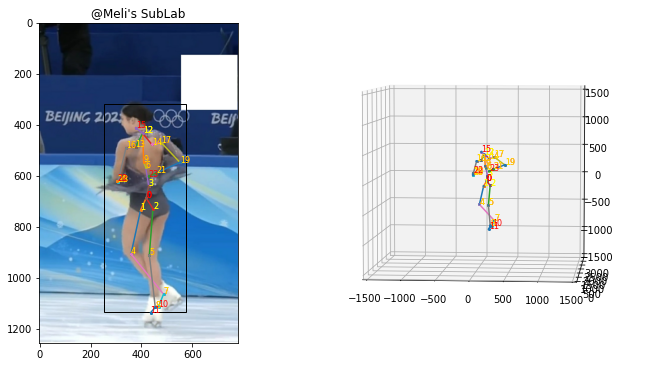

In [ ]:
pred2 = model.detect_poses(jumpEnd, skeleton='smpl_24')
visualize(
    jumpEnd,
    jumpEnd.numpy(), 
    pred2['boxes'].numpy(),
    pred2['poses3d'].numpy(),
    pred2['poses2d'].numpy(),
    model.per_skeleton_joint_edges['smpl_24'].numpy(),
    gif_name = "end")

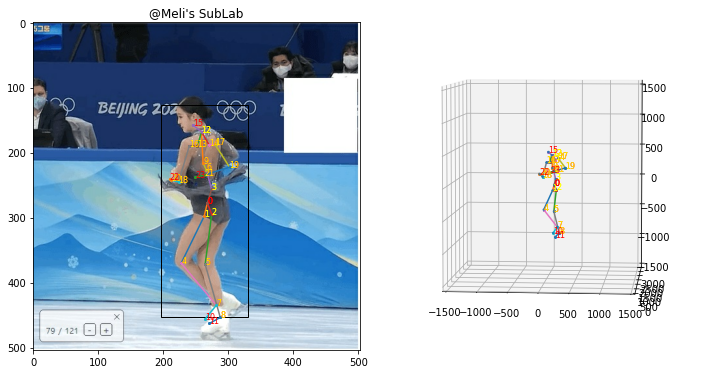

In [ ]:
jumpEnd2 = tf.image.decode_jpeg(tf.io.read_file('axel-end2.jpg'))
pred3 = model.detect_poses(jumpEnd2, skeleton='smpl_24')
visualize(
    jumpEnd2,
    jumpEnd2.numpy(), 
    pred3['boxes'].numpy(),
    pred3['poses3d'].numpy(),
    pred3['poses2d'].numpy(),
    model.per_skeleton_joint_edges['smpl_24'].numpy())

In [ ]:
print(pred['poses3d'].numpy()[0][8],pred['poses3d'].numpy()[0][11] )

[ 361.09686  512.9317  1910.2256 ] [ 429.60464  609.77606 1977.2412 ]


In [ ]:
def get_theta(start,end):
  start = np.array(start)
  end = np.array(end)
  return np.degrees(np.math.atan2(np.linalg.det([start,end]),np.dot(start,end)))

def judge_rotation(jump_type, start_info, end_info):
  theta = None
  end_vector = end_info['poses3d'].numpy()[0][11]-end_info['poses3d'].numpy()[0][8]
  if jump_type == "toe": 
    start_vector = start_info['poses3d'].numpy()[0][11]-start_info['poses3d'].numpy()[0][8]
    theta = get_theta(start_vector[:2], end_vector[:2])
  elif jump_type == "axel":
    start_vector = start_info['poses3d'].numpy()[0][10]-start_info['poses3d'].numpy()[0][7]
    theta = get_theta(start_vector[:2], end_vector[:2])

  print("theta:"+str(theta))
  return start_vector, end_vector

In [ ]:
start_vector, end_vector = judge_rotation("axel", pred, pred2)

theta:1.743803961957435


In [ ]:
start_vector, end_vector = judge_rotation("axel", pred, pred3)

theta:22.839075514892862


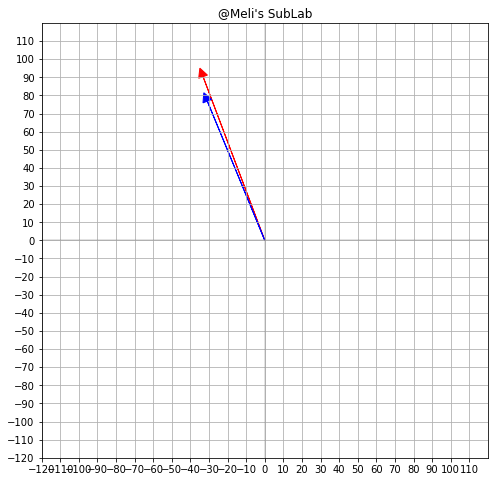

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,8))
plt.title("@Meli's SubLab")
plt.xlim(-120, 120)          
plt.ylim(-120, 120)
plt.xticks(ticks=np.arange(-120, 120, step=10))
plt.yticks(ticks=np.arange(-120, 120, step=10))
plt.arrow(0, 0, start_vector[0], start_vector[1], head_width = 5, head_length = 5, color = 'red')
plt.arrow(0, 0, end_vector[0], end_vector[1], head_width = 5, head_length = 5, color = 'blue')

plt.axhline(0, color='gray', alpha = 0.3)
plt.axvline(0, color='gray', alpha = 0.3)
plt.grid()
plt.show()
plt.savefig("rotation.jpg")